In [1]:
#pySnowRadar modules
import sys
%matplotlib widget

# from pySnowRadar import SnowRadar
# from pySnowRadar.processing import extract_layers
# from pySnowRadar.algorithms import Wavelet_TN, Peakiness

from msc_thesis_functions import *
del sys.modules['msc_thesis_functions']
from msc_thesis_functions import *

#Community packages
import os
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import find_peaks
from datetime import datetime, timedelta
from thefuzz import process, fuzz
from scipy.spatial.distance import cdist
from tqdm import tqdm
import h5py
import cmasher as cmr
import xarray as xr
from scipy.stats import linregress
import matplotlib.colors as mcolors
from pyproj import Transformer
from shapely.geometry import Polygon, Point, MultiPoint, LineString
import numpy as np
import shapely
import seaborn as sns
from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)

from matplotlib.cm import ScalarMappable
pd.options.mode.chained_assignment = None  # default='warn'

from matplotlib.colors import LinearSegmentedColormap

ncolors = 256
color_array = plt.get_cmap('Blues')(range(ncolors))
color_array[:,-1] = np.linspace(0.2,1,ncolors)
map_object = LinearSegmentedColormap.from_list(name='Blues_alpha',colors=color_array)
# 
# register this new colormap with matplotlib
# plt.colormaps.register(cmap=map_object)

from pyproj import Transformer
transformer = Transformer.from_crs(4326, 3413, always_xy=True)

from scipy.constants import speed_of_light


import matplotlib.font_manager as font_manager

font_path= '/Users/torka/Library/Fonts/FiraSans-Light.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

import geopandas as gpd

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


In [2]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection

def plot_polygon(ax, poly, **kwargs):
    path = Path.make_compound_path(
        Path(np.asarray(poly.exterior.coords)[:, :2]),
        *[Path(np.asarray(ring.coords)[:, :2]) for ring in poly.interiors])

    patch = PathPatch(path, **kwargs)
    collection = PatchCollection([patch], **kwargs)
    
    ax.add_collection(collection, autolim=True)
    ax.autoscale_view()
    return collection

In [3]:
sites = [2, 3, 4, 'grid3', 'grid4', 'grid5', 'grid6', 'grid7', 'grid8']

#opening ATM grids
path_ATM= '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/ATM_gridded/gridding_v7'
files = os.listdir(path_ATM)
ATM_data_dict = {}
print('Opening ATM data:')
for site in sites:
    file = [x for x in files if x.split('_')[-1].split('.')[0] == str(site)][0]
    print(f'{site}: {file}')
    ds = xr.open_dataset(os.path.join(path_ATM, file))
    ATM_data_dict[site] = ds
print('------------------')


#opening MP grids
path_MP = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/krigging_onATMgrid_v5_exactTrue'
files = os.listdir(path_MP)
files = [f for f in files if f.endswith('.nc')] 
MP_data_dict = {}
print('Opening MP data:')
for site in sites:
    file = [x for x in files if x.split('_')[1] == str(site)][0]
    print(f'{site}: {file}')
    ds = xr.open_dataset(os.path.join(path_MP, file))
    MP_data_dict[site] = ds
print('------------------')

#opening SR data (Wavelet)
path_SR_Wavelet = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Wavelet/20250204_SRprecision'
SR_Wavelet_data_dict = {}
print('Opening SR Wavelet data:')
for site in sites:
    SR_Wavelet_data_dict[site] = {}
    subpath = os.path.join(path_SR_Wavelet, str(site))
    for i, f in enumerate(os.listdir(subpath)):
        print(f'{site}, {i}: {f}')
        ds = xr.open_dataset(os.path.join(path_SR_Wavelet, str(site), f))
        SR_Wavelet_data_dict[site][i] = ds
print('------------------')


#opening SR data (Peakiness)
path_SR_Peakiness = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/OIB/Peakiness/20250204_SRprecision'
SR_Peakiness_data_dict = {}
print('Opening SR Peakiness data:')

for site in sites:
    SR_Peakiness_data_dict[site] = {}
    subpath = os.path.join(path_SR_Peakiness, str(site))
    for i, f in enumerate(os.listdir(subpath)):
        print(f'{site}, {i}: {f}')
        ds = xr.open_dataset(os.path.join(path_SR_Peakiness, str(site), f))
        SR_Peakiness_data_dict[site][i] = ds
        
#opening shapefiles
path_shapefiles = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/grid_extents_v4'
shape_dict = {}
for site in sites:
    file = [x for x in os.listdir(path_shapefiles) if x.split('_')[1] == str(site) and x.endswith('shp')][0]
    print(f'{site}: {file}')
    shape_dict[site] = gpd.read_file(os.path.join(path_shapefiles, file))


#open snow pit data
snow_pit_dict = {}
path_to_snow_pit  = '/Users/torka/Library/CloudStorage/OneDrive-Personal/MarineSciences/MasterThs-T/Data/Eureka/SnowPits/processed'
files = os.listdir(path_to_snow_pit)
for site in sites: 
    snow_pit_dict[site] = {}
    if type(site) == str:
        site_files = [f for f in files if f.split('_')[1] == str(site)]
        for file in site_files:
            pit_nr = file.split('_')[2].split('.')[0]
            print(f'{site}: {pit_nr}')
            snow_pit_dict[site][pit_nr] = pd.read_csv(os.path.join(path_to_snow_pit, file))

Opening ATM data:
2: EUREKA2014_ATM_gridded_2.nc
3: EUREKA2014_ATM_gridded_3.nc
4: EUREKA2014_ATM_gridded_4.nc
grid3: EUREKA2016_ATM_gridded_grid3.nc
grid4: EUREKA2016_ATM_gridded_grid4.nc
grid5: EUREKA2016_ATM_gridded_grid5.nc
grid6: EUREKA2016_ATM_gridded_grid6.nc
grid7: EUREKA2016_ATM_gridded_grid7.nc
grid8: EUREKA2016_ATM_gridded_grid8.nc
------------------
Opening MP data:
2: EUREKA2014_2_krigged_MP_snow_depth.nc
3: EUREKA2014_3_krigged_MP_snow_depth.nc
4: EUREKA2014_4_krigged_MP_snow_depth.nc
grid3: EUREKA2016_grid3_krigged_MP_snow_depth.nc
grid4: EUREKA2016_grid4_krigged_MP_snow_depth.nc
grid5: EUREKA2016_grid5_krigged_MP_snow_depth.nc
grid6: EUREKA2016_grid6_krigged_MP_snow_depth.nc
grid7: EUREKA2016_grid7_krigged_MP_snow_depth.nc
grid8: EUREKA2016_grid8_krigged_MP_snow_depth.nc
------------------
Opening SR Wavelet data:
2, 0: IRSNO1B_20140325_02_175_deconv.nc
2, 1: IRSNO1B_20140325_02_229_deconv.nc
2, 2: IRSNO1B_20140325_02_125_deconv.nc
2, 3: IRSNO1B_20140325_02_069_deconv.n

In [67]:
SR_Wavelet_data_dict[site][i]

<xarray.Dataset> Size: 42MB
Dimensions:                   (range_bin: 1266, time: 1027)
Coordinates:
    elevation_axii            (range_bin, time) float64 10MB 10.02 ... -4.92
  * range_bin                 (range_bin) int32 5kB 0 1 2 3 ... 1263 1264 1265
  * time                      (time) datetime64[ns] 8kB 2016-04-19T13:03:37 ....
    along_track_distance      (time) float64 8kB 0.0 4.833 ... 4.972e+03
    lon                       (time) float64 8kB -86.79 -86.79 ... -86.78 -86.78
    lat                       (time) float64 8kB 80.05 80.05 ... 80.09 80.09
    x                         (time) float64 8kB -7.202e+05 ... -7.168e+05
    y                         (time) float64 8kB -8.059e+05 ... -8.023e+05
Data variables: (12/25)
    radar_data                (range_bin, time) float32 5MB 0.01134 ... 1.651
    SNR                       (range_bin, time) float32 5MB -2.083 ... 18.47
    wavelet_coefs_log         (range_bin, time) float64 10MB 0.0 0.0 ... 0.0 0.0
    wavelet_coefs_lin         (range_bin, time) float64 10MB 0.0 0.0 ... 0.0 0.0
    noise                     (time) float32 4kB 0.01832 0.01582 ... 0.0235
    precision                 (time) float32 4kB 0.01466 0.01402 ... 0.01299
    ...                        ...
    snow_ice_ratio            (time) float64 8kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    snow_depth                (time) float64 8kB 0.18 0.17 0.2 ... 0.19 0.15
    max_elevation             (time) float64 8kB -0.2438 -0.2467 ... -0.13
    ATM_classes               float64 8B nan
    ATM_as_interfaces_mean    float64 8B nan
    ATM_as_interfaces_90      float64 8B nan
Attributes: (12/13)
    radar_name:             snow3
    src:                    IRSNO1B_20160419_04_006_deconv.nc
    picker:                 Wavelet_TN
    bandwidth:              6000000000.0
    center_frequency:       375000000.0
    n_snow:                 1.297700561122876
    ...                     ...
    delta_fast_time_range:  0.012975781596235731
    level_ice_elevation:    6.114212030383911
    number_averages:        16.0
    PRF:                    1953.125
    velocity:               118.37122052854495
    ATM_data:               None

In [68]:
SR_Peakiness_data_dict[site][i]


<xarray.Dataset> Size: 137kB
Dimensions:                 (range_bin: 1266, time: 1027)
Coordinates:
  * range_bin               (range_bin) int32 5kB 0 1 2 3 ... 1263 1264 1265
  * time                    (time) datetime64[ns] 8kB 2016-04-19T13:03:37 ......
    along_track_distance    (time) float64 8kB 0.0 4.833 ... 4.967e+03 4.972e+03
    lon                     (time) float64 8kB -86.79 -86.79 ... -86.78 -86.78
    lat                     (time) float64 8kB 80.05 80.05 80.05 ... 80.09 80.09
    x                       (time) float64 8kB -7.202e+05 ... -7.168e+05
    y                       (time) float64 8kB -8.059e+05 ... -8.023e+05
Data variables: (12/13)
    altitude                (time) float64 8kB 523.0 523.0 523.0 ... 523.0 523.0
    roll                    (time) float64 8kB 1.54 1.532 ... 0.03129 0.01759
    pitch                   (time) float64 8kB 0.9542 0.9509 ... 1.195 1.191
    precision               (time) float64 8kB nan 0.01391 nan ... nan nan nan
    air_snow_index          (time) float64 8kB nan 783.0 nan ... 786.0 784.0 nan
    snow_ice_index          (time) float64 8kB nan 795.0 nan ... 786.0 784.0 nan
    ...                      ...
    snow_ice_elevation      (time) float64 8kB nan -0.008318 nan ... 0.09869 nan
    snow_depth              (time) float64 8kB nan 0.12 nan 0.0 ... 0.0 0.0 nan
    max_elevation           (time) float64 8kB -0.03404 -0.008318 ... 0.08274
    ATM_classes             float64 8B nan
    ATM_as_interfaces_mean  float64 8B nan
    ATM_as_interfaces_90    float64 8B nan
Attributes:
    radar_name:             snow3
    src:                    IRSNO1B_20160419_04_006_deconv.nc
    picker:                 Peakiness
    bandwidth:              6000000000.0
    center_frequency:       375000000.0
    n_snow:                 1.297700561122876
    null_2_space:           0.19986163866666665
    delta_fast_time_range:  0.012975781596235731
    level_ice_elevation:    5.849005767982612
    number_averages:        16.0
    PRF:                    1953.125
    velocity:               118.37122052854495

In [69]:

############
# 
footprint_mode = 'pulse_limited_unfocused'
include_moving_windows = True

if include_moving_windows:
    moving_windows = [3,5,7,9]
    
############

df_master_dict = {}
df_tmp_dict = {}

for site in tqdm(sites):
    df_tmp_dict[site] = {}
    
    for i in SR_Wavelet_data_dict[site].keys():
    
        
        ds =  SR_Wavelet_data_dict[site][i]
        df_tmp = SR_Wavelet_data_dict[site][i].to_dataframe().loc[0]
        
        
        # get PEAK measurements 
        df_tmp_tmp = SR_Peakiness_data_dict[site][i].to_dataframe().loc[0]
        df_tmp_tmp.reset_index(inplace=True)
        
        df_tmp['air_snow_elevation_peakiness'] = df_tmp_tmp['air_snow_elevation'].to_list()
        df_tmp['snow_ice_elevation_peakiness'] = df_tmp_tmp['snow_ice_elevation'].to_list()
        df_tmp['snow_depth_peakiness'] = df_tmp_tmp['snow_depth'].to_list()
        
        df_tmp['precision_peakiness'] = df_tmp_tmp['precision'].to_list()
        
        # level surface difference between CWT and PEAK
        level_surface_difference = SR_Wavelet_data_dict[site][i].attrs['level_ice_elevation'] - SR_Peakiness_data_dict[site][i].attrs['level_ice_elevation']
        df_tmp['level_surface_difference'] = [level_surface_difference] * len(df_tmp)
        
        if include_moving_windows:
            for length in moving_windows:
                df_tmp[f'air_snow_elevation_rolled_{length}'] = df_tmp['air_snow_elevation'].rolling(window=length, min_periods=1, center=True).mean()
                df_tmp[f'snow_ice_elevation_rolled_{length}'] = df_tmp['snow_ice_elevation'].rolling(window=length, min_periods=1, center=True).mean()
                
                df_tmp[f'air_snow_elevation_peak_rolled_{length}'] = df_tmp['air_snow_elevation_peakiness'].rolling(window=length, min_periods=1, center=True).mean()
                df_tmp[f'snow_ice_elevation_peak_rolled_{length}'] = df_tmp['snow_ice_elevation_peakiness'].rolling(window=length, min_periods=1, center=True).mean()
            
        # print()
        # waveforms = []
        # for k in range(len(df_tmp)):
        #     waveforms.append(SR_Wavelet_data_dict[site][i]['radar_data'].values[:,k])
            
        # df_tmp['waveform'] = waveforms 
        
        df_tmp.reset_index(inplace=True)
        # break
        #add site, ice age and overflight information
        df_tmp['site'] = [site] * len(df_tmp)    
        df_tmp['ice_age'] = df_tmp['site'].apply(lambda x: 'myi' if x=='grid8' or x=='grid5' else 'fyi') 
        df_tmp['overflight_nr'] = [i] * len(df_tmp) 

        #add footprints
        df_tmp, sr_footprints = construct_footprints_theoretical(df_tmp, ds, mode=footprint_mode)
        # sr_footprints = [affinity.scale(fp, xfact=scale, yfact=scale) for fp in sr_footprints]
        
        df_tmp['footprints'] = sr_footprints
        df_tmp['footprint_area'] = df_tmp['footprints'].apply(lambda x: x.area)

        xx, yy = np.meshgrid(ATM_data_dict[site]['easting'], ATM_data_dict[site]['northing'], indexing='xy')
        zz_ATM = ATM_data_dict[site]['elevation'].values.flatten()

        mask = ~np.isnan(zz_ATM)
        xx = xx.flatten()[mask]
        yy = yy.flatten()[mask]

        poly_points_indices_wavelet = points_in_poly_list(df_tmp['footprints'], list(zip(xx, yy)), np.mean(df_tmp['footprint_area']) * .65 if footprint_mode == 'pulse_limited_unfocused' else 1)
        wavelet_indices = list(poly_points_indices_wavelet.keys())
        df_tmp = df_tmp.loc[wavelet_indices] #delete not fully-covered footprints

        df_tmp['grid_indices'] = poly_points_indices_wavelet
        df_tmp['grid_x'] = df_tmp['grid_indices'].apply(lambda x: xx[x])
        df_tmp['grid_y'] = df_tmp['grid_indices'].apply(lambda x: yy[x])
        df_tmp['grid_dists'] = df_tmp.apply(lambda x: np.sqrt((x.grid_x - x.x)**2 + (x.grid_y - x.y)**2), axis=1)        

        # add ATM 
        df_tmp['ATM_elev'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['elevation'].values.flatten()[mask][x])
        df_tmp['ATM_elev_uncertainty'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['standard_deviation'].values.flatten()[mask][x])    
        df_tmp['ATM_htopo'] = df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .95) - np.quantile(x, .05))
        df_tmp['ATM_slope'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['slope'].values.flatten()[mask][x])
        df_tmp['ATM_roughness'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['roughness'].values.flatten()[mask][x])
        df_tmp['deformation'] = df_tmp['grid_indices'].apply(lambda x: ATM_data_dict[site]['classes'].values.flatten()[mask][x])
        df_tmp['deformation_flag'] = df_tmp['deformation'].apply(lambda x: 1 if np.nanmedian(x) > .1 else 0)

        # add MP
        df_tmp['MP_snow_depth'] = df_tmp['grid_indices'].apply(lambda x: MP_data_dict[site]['snow_depth'].values.flatten()[mask][x])
        df_tmp['MP_snow_depth_uncertainty'] = df_tmp['grid_indices'].apply(lambda x: MP_data_dict[site]['snow_depth_uncertainty'].values.flatten()[mask][x])
        

            # df_tmp['MP_snow_depth_uncerainty_rolled'] = roll_MP_snow_depth(df_tmp, length)
            
        # add the rolled MP
        # for r in rolling_windows:
        #     df_tmp[f'MP_snow_depth_{r}'] = df_tmp['grid_indices'].apply(lambda x: MP_data_rolled_dict[site][r]['snow_depth'].values.flatten()[mask][x])
        #     df_tmp[f'MP_snow_depth_uncertainty_{r}'] = df_tmp['grid_indices'].apply(lambda x: MP_data_rolled_dict[site][r]['snow_depth_uncertainty'].values.flatten()[mask][x])
            
        offset_wavelet = np.mean(df_tmp['air_snow_elevation'] - df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .5)))
        offset_peakiness = np.mean(df_tmp['air_snow_elevation_peakiness'] - df_tmp['ATM_elev'].apply(lambda x: np.quantile(x, .5)))
        
        if include_moving_windows:
            for length in moving_windows:
                df_tmp[f'MP_snow_depth_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='MP_snow_depth', window_size=length)
                
                df_tmp[f'ATM_elev_rolled_{length}'] = roll_MP_snow_depth(df_tmp, var='ATM_elev', window_size=length)
                df_tmp[f'ATM_elev_wavelet_rolled_{length}'] = df_tmp[f'ATM_elev_rolled_{length}'].apply(lambda x: x + offset_wavelet)
            
        df_tmp['ATM_elev_wavelet'] = df_tmp['ATM_elev'].apply(lambda x: x + offset_wavelet)
        df_tmp['ATM_elev_peakiness'] = df_tmp['ATM_elev'].apply(lambda x: x + offset_peakiness)

        df_tmp = df_tmp.loc[(abs(df_tmp['roll']) < 3) & abs((df_tmp['pitch']) < 3)]
        df_tmp = df_tmp.loc[df_tmp['MP_snow_depth'].apply(lambda x: len(x[~np.isnan(x)]) > 10)]

        df_tmp.reset_index(inplace=True, drop=True)
        
        if len (df_tmp) > 0:
            df_tmp_dict[site][i] = df_tmp
        
            if i == list(SR_Wavelet_data_dict[site].keys())[0]:
                df_master = df_tmp
            else:
                df_master = pd.concat([df_master, df_tmp], axis=0)
            
        df_master.reset_index(inplace=True, drop=True)
        
    if site == 2:
        df_supermaster = df_master
    else:
        df_supermaster = pd.concat([df_supermaster, df_master], axis=0)
        
    df_master_dict[site] = df_master
    
df_supermaster.reset_index(inplace=True, drop=True)


df_supermaster['snow_depth_MAX'] = df_supermaster['ATM_elev'].apply(lambda x: np.nanmean(x)) -  df_supermaster['max_elevation']

100%|██████████| 9/9 [06:26<00:00, 42.94s/it]


### FYI, UNDEFORMED

/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_21674/3025606699.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol = ax[0].pcolormesh(Y.T, SR_Wavelet_data_dict[site][overflight_nr]['elevation_axii'],


1
2
3


/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_21674/3025606699.py:237: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


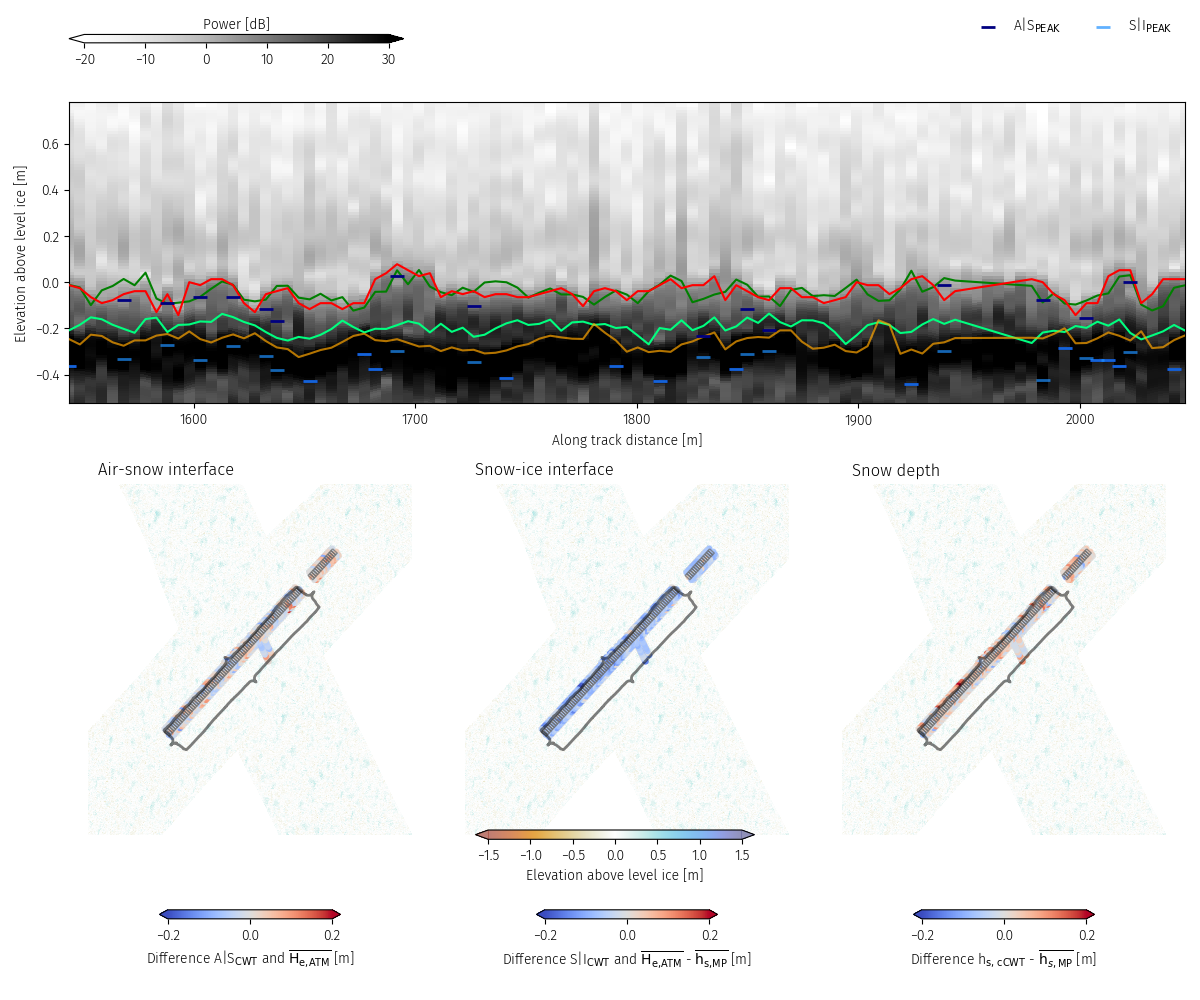

In [75]:
from matplotlib.gridspec import GridSpec

site = 'grid6'
overflight_nr = 4

pit_colors = ['C0', 'C1', 'C2']
df = df_master_dict[site]

fig = plt.figure(figsize=(12, 10))


# Define a 2x3 grid with specific height ratios
gs = GridSpec(2, 3, height_ratios=[1.5, 2], figure=fig)
ax = [0] * 4
# Add a single plot for the top row spanning all columns
ax[0] = fig.add_subplot(gs[0, :])  # Row 0, all columns
# Add three plots for the bottom row
ax[1] = fig.add_subplot(gs[1, 0])  # Row 1, column 0
ax[2] = fig.add_subplot(gs[1, 1], sharex=ax[1], sharey=ax[1])  # Row 1, column 1
ax[3] = fig.add_subplot(gs[1, 2], sharex=ax[1], sharey=ax[1])  # Row 1, column 2

#ECHOGRAM
_, Y = np.meshgrid(range(len(SR_Wavelet_data_dict[site][overflight_nr]['range_bin'])), SR_Wavelet_data_dict[site][overflight_nr]['along_track_distance'])
pcol = ax[0].pcolormesh(Y.T, SR_Wavelet_data_dict[site][overflight_nr]['elevation_axii'],
                                        10 * np.log10(SR_Wavelet_data_dict[site][overflight_nr]['radar_data']),
                                        cmap='Greys',
                                        vmin=-20,vmax=30
                                        )

#CWT INTERFACES
ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'], zorder=100000, color='red')
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'].rolling(window=3,center=True, min_periods=1).mean(), df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'].rolling(window=3,center=True, min_periods=1).mean(), zorder=100000, color='red')

# ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
#         df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'] + df.loc[df['overflight_nr'] == overflight_nr,'precision'],
#         df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'] - df.loc[df['overflight_nr'] == overflight_nr,'precision'],
#         color='red',
#         alpha=.3,
#         zorder=10000,
#         label=r'A|S$_{\text{CWT}}$'
        # )

ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'], zorder=100000, color='orange', alpha=.7)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'].rolling(window=3,center=True, min_periods=1).mean(), df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'].rolling(window=3,center=True, min_periods=1).mean(), zorder=100000, color='orange')

# ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
#         df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'] + df.loc[df['overflight_nr'] == overflight_nr,'precision'],
#         df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'] - df.loc[df['overflight_nr'] == overflight_nr,'precision'],
#         color='orange',
#         alpha=.3,
#         zorder=10000,
#         label=r'S|I$_{\text{CWT}}$'
#         )

#PEAK INTERFACES
ax[0].scatter(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation_peakiness'] -  df.loc[df['overflight_nr'] == overflight_nr,'level_surface_difference'], zorder=100000, color='navy', label=r'A|S$_{\text{PEAK}}$', s=100, marker='_',lw=2)
ax[0].scatter(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation_peakiness'] -  df.loc[df['overflight_nr'] == overflight_nr,'level_surface_difference'], zorder=100000, color='dodgerblue', alpha=.7, label=r'S|I$_{\text{PEAK}}$', s=100, marker='_',lw=2)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,f'air_snow_elevation_rolled_{5}'], zorder=100000, color='red',ls='--', alpha=.7)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,f'snow_ice_elevation_rolled_{5}'], zorder=100000, color='orange', alpha=.3,ls='--')
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation_peakiness_offset'], zorder=100000, color='navy', label=r'A|S$_{\text{PEAK}}$')
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation_peakiness_offset'], zorder=100000, color='deepskyblue', alpha=.7, label=r'S|I$_{\text{PEAK}}$')

#ATM A\S INTERFACE
ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
              df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5)),
                        zorder=50,
                        color='green',
                        )
ATM_error = np.sqrt(df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_uncertainty'].apply(lambda x: np.mean(x))**2 + 0.07**2)
# ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
#                 df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5))-ATM_error,
#                 df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5))+ATM_error,
#                 alpha=0.3,
#                 zorder=10000,
#                 label=r'ATM$_{\text{mean}}$',
#                 color='green'
#                 )

#ATM&MP S\I INTERFACE
MP_error = np.sqrt(df.loc[df['overflight_nr'] == overflight_nr,'MP_snow_depth_uncertainty'].apply(lambda x: np.nanmean(x))**2)
y =  df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) - df.loc[df['overflight_nr'] == overflight_nr,'MP_snow_depth'].apply(lambda x: np.nanmean(x))
ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
              y,
                        zorder=50,
                        color='springgreen',
                        )
# ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
#         y + np.sqrt(MP_error**2 + ATM_error**2),
#         y - np.sqrt(MP_error**2 + ATM_error**2),
#         color='springgreen',
#         alpha=.3,
#         zorder=10000,
#         label=r'ATM$_{\text{mean}}$ & MP$_{\text{mean}}$'
#         )

#add snow pit locations
# for i, pit_nr in enumerate(snow_pit_dict[site].keys()):
#     closest_along = snow_pit_dict[site][pit_nr]['x'], 
#     closest_along = df.loc[df['overflight_nr'] == overflight_nr].iloc[np.argmin((df.loc[df['overflight_nr'] == overflight_nr,'y'] - snow_pit_dict[site][pit_nr]['y'][0])**2 + (df.loc[df['overflight_nr'] == overflight_nr,'x'] - snow_pit_dict[site][pit_nr]['x'][0])**2)]['along_track_distance']
#     ax[0].axvline(closest_along, color=pit_colors[i],ls='--', label='Snow pit' if pit_nr == list(snow_pit_dict[site].keys())[0] else None)


ax[0].set_ylim(min(df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation']) -0.2, max(df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation']) + 0.7)
ax[0].set_xlim(min(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']), max(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']))


ax[0].set_ylabel('Elevation above level ice [m]')
ax[0].set_xlabel('Along track distance [m]')
cbar = fig.colorbar(pcol, ax=ax[0], orientation='horizontal',location='top',
                    anchor=(0,0.85),
                    label='Power [dB]',
                    shrink=.3,
                    extend='both',
                    aspect=40
                    )
cbar.ax.xaxis.set_ticks_position('bottom')

leg = ax[0].legend(loc='upper right',ncols=3, bbox_to_anchor=(1, 1.33), frameon=False)
leg.set_zorder(1000)


#LOWER ROW PLOTS
for i in range(1,4):
    print(i)
    ax[i].set_aspect('equal')
    ax[i].axis('off')
    ax[i].plot(shape_dict[site].geometry[0].exterior.xy[0], shape_dict[site].geometry[0].exterior.xy[1], color='black', linewidth=2, zorder=1000, alpha=.5) 
    xlim = ax[i].get_xlim()    
    ylim = ax[i].get_ylim()
    for fp in df['footprints']:
        plot_polygon(ax[i], fp, edgecolor='grey', facecolor='none', zorder=100, lw=.1, alpha=.7)
        
    for fp, dist in zip(df.loc[df['overflight_nr'] == overflight_nr,'footprints'], df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']):
        plot_polygon(ax[i], fp, edgecolor='dimgrey', facecolor='none', zorder=500, lw=1, alpha=.7)
        
    pcol = ax[i].pcolormesh(ATM_data_dict[site]['easting'], ATM_data_dict[site]['northing'], ATM_data_dict[site]['elevation'],
                cmap=cmr.prinsenvlag,
                norm=mcolors.TwoSlopeNorm(vmin=-1.5, vcenter=0 , vmax=1.5),
                alpha=.75,
                )


cbar = fig.colorbar(pcol, ax=ax[1:4],
                    orientation='horizontal',
                    label='Elevation above level ice [m]',
                    shrink=.3,
                    extend='both',
                    aspect=30,
                    # anchor=(1.74,0.5),
                    )
# cbar.ax.xaxis.set_label_position('top')


ax[1].set_title('Air-snow interface', ha='left', x=0.03)
ax[2].set_title('Snow-ice interface', ha='left', x=0.03)
ax[3].set_title('Snow depth', ha='left', x=0.03)

# for i, pit_nr in enumerate(snow_pit_dict[site].keys()):
#     ax[1].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
#     ax[2].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
#     ax[3].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
    
scat = ax[1].scatter(df['x'], df['y'], c=df['air_snow_elevation'] - df['ATM_elev_wavelet'].apply(lambda x: np.nanquantile(x, .5)),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )

cbar = fig.colorbar(scat, ax=ax[1], orientation='horizontal',
                    label=r'Difference A|S$_{\text{CWT}}$ and $\overline{\text{H}_{\text{e,ATM}}}$ [m]',
                    shrink=.5,
                    extend='both',
                    anchor=(0.5,1),
                    
                    )

scat = ax[2].scatter(df['x'], df['y'], c=df['snow_ice_elevation'] - (df['ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) -  df['MP_snow_depth'].apply(lambda x: np.nanmean(x))),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )

cbar = fig.colorbar(scat, ax=ax[2], orientation='horizontal',
                    label=r'Difference S|I$_{\text{CWT}}$ and $\overline{\text{H}_{\text{e,ATM}}}$ - $\overline{\text{h}_{\text{s,MP}}}$ [m]',
                    shrink=.5,
                    extend='both',
                    anchor=(0.5,1),
                    
                    )

scat = ax[3].scatter(df['x'], df['y'], c=df['snow_depth'] - df['MP_snow_depth'].apply(lambda x: np.nanquantile(x, .9)),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )

cbar = fig.colorbar(scat, ax=ax[3], orientation='horizontal',
                    label=r'Difference h$_{\text{s, cCWT}}$ - $\overline{\text{h}_{s,\text{MP}}}$ [m]',
                    shrink=.5,
                    extend='both',
                    anchor=(0.5,1),
                    # 
                    )

for i in range(1,4):
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
    
xlim_low = ax[1].get_xlim()[0]
xlim_high = ax[1].get_xlim()[1]

ylim_low = ax[1].get_ylim()[0]
ylim_high = ax[1].get_ylim()[1]

df_f = df.loc[df['overflight_nr'] == overflight_nr]
df_subset = df_f.loc[(df_f['x'] > xlim_low) & (df_f['x'] < xlim_high) & (df_f['y'] > ylim_low) & (df_f['y'] < ylim_high)]
along_min = df_subset['along_track_distance'].min()
along_max = df_subset['along_track_distance'].max()
# vspan = ax[0].axvspan(along_min, along_max, zorder=100, alpha=.2, edgecolor='black')


def update_vspan(event):
    xlim_low, xlim_high = ax[1].get_xlim()
    df_subset = df_f.loc[(df_f['x'] > xlim_low) & (df_f['x'] < xlim_high) & (df_f['y'] > ylim_low) & (df_f['y'] < ylim_high)]
    along_min = df_subset['along_track_distance'].min()
    along_max = df_subset['along_track_distance'].max()

    points = np.array([[along_min, ax[0].get_ylim()[0]], [along_max, ax[0].get_ylim()[0]], [along_max, ax[0].get_ylim()[1]], [along_min, ax[0].get_ylim()[1]]])
    vspan.set_xy(points )
    fig.canvas.draw_idle()

ax[1].callbacks.connect('xlim_changed', update_vspan)

fig.tight_layout() 
plt.show()


/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_21674/591156542.py:24: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol = ax[0].pcolormesh(Y.T, SR_Wavelet_data_dict[site][overflight_nr]['elevation_axii'],
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1
2
3


/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_21674/591156542.py:239: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


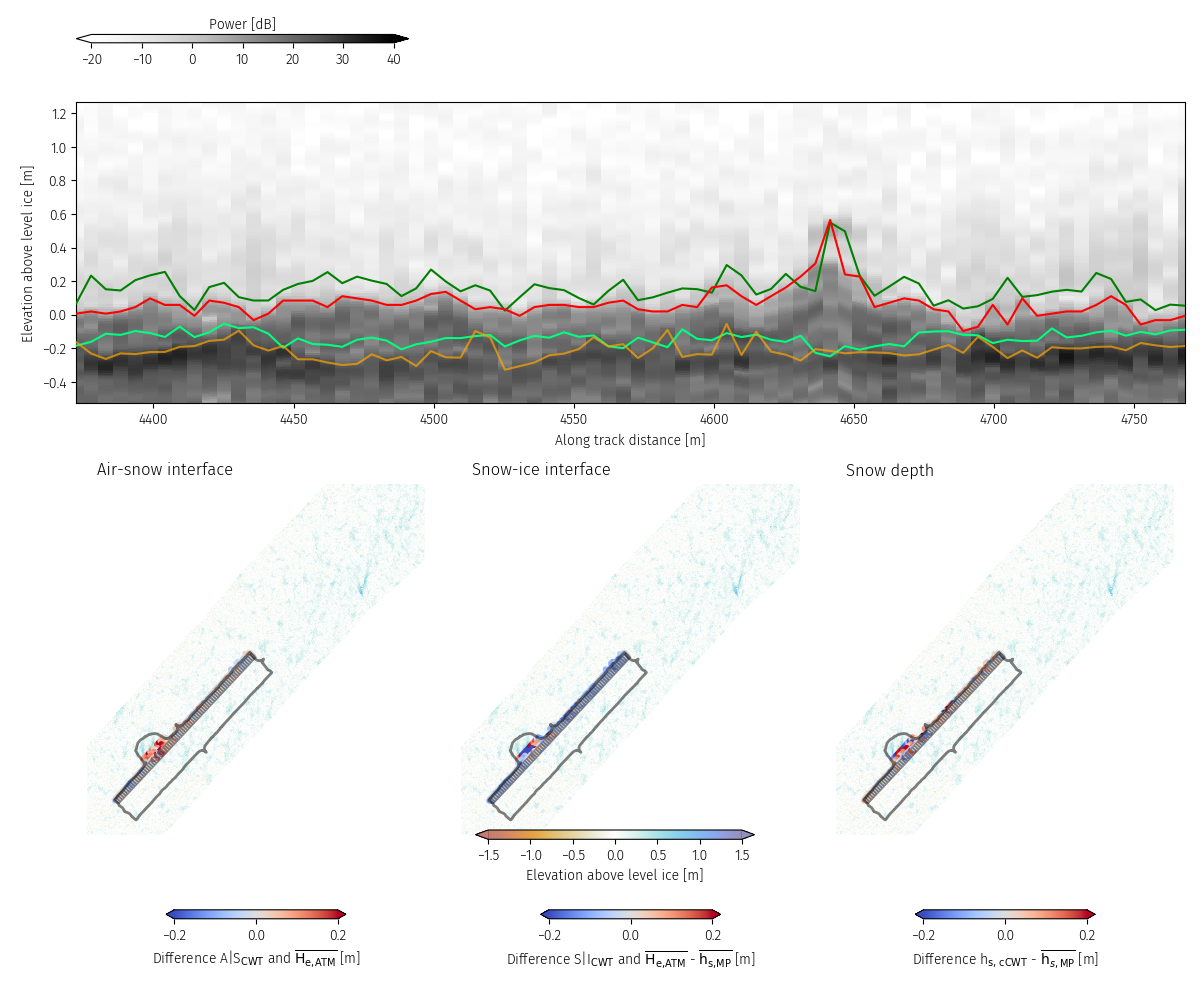

In [33]:
from matplotlib.gridspec import GridSpec

site = 'grid3'
overflight_nr = 2

pit_colors = ['C0', 'C1', 'C2']
df = df_master_dict[site]

fig = plt.figure(figsize=(12, 10))


# Define a 2x3 grid with specific height ratios
gs = GridSpec(2, 3, height_ratios=[1.5, 2], figure=fig)
ax = [0] * 4
# Add a single plot for the top row spanning all columns
ax[0] = fig.add_subplot(gs[0, :])  # Row 0, all columns
# Add three plots for the bottom row
ax[1] = fig.add_subplot(gs[1, 0])  # Row 1, column 0
ax[2] = fig.add_subplot(gs[1, 1], sharex=ax[1], sharey=ax[1])  # Row 1, column 1
ax[3] = fig.add_subplot(gs[1, 2], sharex=ax[1], sharey=ax[1])  # Row 1, column 2

#ECHOGRAM
_, Y = np.meshgrid(range(len(SR_Wavelet_data_dict[site][overflight_nr]['range_bin'])), SR_Wavelet_data_dict[site][overflight_nr]['along_track_distance'])
pcol = ax[0].pcolormesh(Y.T, SR_Wavelet_data_dict[site][overflight_nr]['elevation_axii'],
                                        10 * np.log10(SR_Wavelet_data_dict[site][overflight_nr]['radar_data']),
                                        cmap='Greys',
                                        vmin=-20,vmax=40
                                        )

#CWT INTERFACES
ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'], zorder=100000, color='red')
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'].rolling(window=3,center=True, min_periods=1).mean(), df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'].rolling(window=3,center=True, min_periods=1).mean(), zorder=100000, color='red')

# ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
#         df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'] + df.loc[df['overflight_nr'] == overflight_nr,'precision'],
#         df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'] - df.loc[df['overflight_nr'] == overflight_nr,'precision'],
#         color='red',
#         alpha=.3,
#         zorder=10000,
#         label=r'A|S$_{\text{CWT}}$'
        # )

ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'], zorder=100000, color='orange', alpha=.7)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'].rolling(window=3,center=True, min_periods=1).mean(), df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'].rolling(window=3,center=True, min_periods=1).mean(), zorder=100000, color='orange')

# ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
#         df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'] + df.loc[df['overflight_nr'] == overflight_nr,'precision'],
#         df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'] - df.loc[df['overflight_nr'] == overflight_nr,'precision'],
#         color='orange',
#         alpha=.3,
#         zorder=10000,
#         label=r'S|I$_{\text{CWT}}$'
#         )

#PEAK INTERFACES
# ax[0].scatter(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation_peakiness'], zorder=100000, color='navy', label=r'A|S$_{\text{PEAK}}$', s=100, marker='_',lw=2)
# ax[0].scatter(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation_peakiness'], zorder=100000, color='dodgerblue', alpha=.7, label=r'S|I$_{\text{PEAK}}$', s=100, marker='_',lw=2)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,f'air_snow_elevation_rolled_{5}'], zorder=100000, color='red',ls='--', alpha=.7)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,f'snow_ice_elevation_rolled_{5}'], zorder=100000, color='orange', alpha=.3,ls='--')
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation_peakiness_offset'], zorder=100000, color='navy', label=r'A|S$_{\text{PEAK}}$')
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation_peakiness_offset'], zorder=100000, color='deepskyblue', alpha=.7, label=r'S|I$_{\text{PEAK}}$')

#ATM A\S INTERFACE
ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
              df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev'].apply(lambda x: np.quantile(x, .9)),
                        zorder=50,
                        color='green',
                        )
ATM_error = np.sqrt(df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_uncertainty'].apply(lambda x: np.mean(x))**2 + 0.07**2)
# ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
#                 df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5))-ATM_error,
#                 df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5))+ATM_error,
#                 alpha=0.3,
#                 zorder=10000,
#                 label=r'ATM$_{\text{mean}}$',
#                 color='green'
#                 )

#ATM&MP S\I INTERFACE
MP_error = np.sqrt(df.loc[df['overflight_nr'] == overflight_nr,'MP_snow_depth_uncertainty'].apply(lambda x: np.nanmean(x))**2)
y =  df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) - df.loc[df['overflight_nr'] == overflight_nr,'MP_snow_depth'].apply(lambda x: np.nanmean(x))


ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
             y,
                        zorder=50,
                        color='springgreen',
                        )
# ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
#         y + np.sqrt(MP_error**2 + ATM_error**2),
#         y - np.sqrt(MP_error**2 + ATM_error**2),
#         color='springgreen',
#         alpha=.3,
#         zorder=10000,
#         label=r'ATM$_{\text{mean}}$ & MP$_{\text{mean}}$'
#         )

#add snow pit locations
# for i, pit_nr in enumerate(snow_pit_dict[site].keys()):
#     closest_along = snow_pit_dict[site][pit_nr]['x'], 
#     closest_along = df.loc[df['overflight_nr'] == overflight_nr].iloc[np.argmin((df.loc[df['overflight_nr'] == overflight_nr,'y'] - snow_pit_dict[site][pit_nr]['y'][0])**2 + (df.loc[df['overflight_nr'] == overflight_nr,'x'] - snow_pit_dict[site][pit_nr]['x'][0])**2)]['along_track_distance']
#     ax[0].axvline(closest_along, color=pit_colors[i],ls='--', label='Snow pit' if pit_nr == list(snow_pit_dict[site].keys())[0] else None)


ax[0].set_ylim(min(df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation']) -0.2, max(df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation']) + 0.7)
ax[0].set_xlim(min(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']), max(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']))


ax[0].set_ylabel('Elevation above level ice [m]')
ax[0].set_xlabel('Along track distance [m]')
cbar = fig.colorbar(pcol, ax=ax[0], orientation='horizontal',location='top',
                    anchor=(0,0.85),
                    label='Power [dB]',
                    shrink=.3,
                    extend='both',
                    aspect=40
                    )
cbar.ax.xaxis.set_ticks_position('bottom')

leg = ax[0].legend(loc='upper right',ncols=3, bbox_to_anchor=(1, 1.33), frameon=False)
leg.set_zorder(1000)


#LOWER ROW PLOTS
for i in range(1,4):
    print(i)
    ax[i].set_aspect('equal')
    ax[i].axis('off')
    ax[i].plot(shape_dict[site].geometry[0].exterior.xy[0], shape_dict[site].geometry[0].exterior.xy[1], color='black', linewidth=2, zorder=1000, alpha=.5) 
    xlim = ax[i].get_xlim()    
    ylim = ax[i].get_ylim()
    for fp in df['footprints']:
        plot_polygon(ax[i], fp, edgecolor='grey', facecolor='none', zorder=100, lw=.1, alpha=.7)
        
    for fp, dist in zip(df.loc[df['overflight_nr'] == overflight_nr,'footprints'], df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']):
        plot_polygon(ax[i], fp, edgecolor='dimgrey', facecolor='none', zorder=500, lw=1, alpha=.7)
        
    pcol = ax[i].pcolormesh(ATM_data_dict[site]['easting'], ATM_data_dict[site]['northing'], ATM_data_dict[site]['elevation'],
                cmap=cmr.prinsenvlag,
                norm=mcolors.TwoSlopeNorm(vmin=-1.5, vcenter=0 , vmax=1.5),
                alpha=.75,
                )


cbar = fig.colorbar(pcol, ax=ax[1:4],
                    orientation='horizontal',
                    label='Elevation above level ice [m]',
                    shrink=.3,
                    extend='both',
                    aspect=30,
                    # anchor=(1.74,0.5),
                    )
# cbar.ax.xaxis.set_label_position('top')


ax[1].set_title('Air-snow interface', ha='left', x=0.03)
ax[2].set_title('Snow-ice interface', ha='left', x=0.03)
ax[3].set_title('Snow depth', ha='left', x=0.03)

# for i, pit_nr in enumerate(snow_pit_dict[site].keys()):
#     ax[1].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
#     ax[2].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
#     ax[3].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
    
scat = ax[1].scatter(df['x'], df['y'], c=df['air_snow_elevation'] - df['ATM_elev_wavelet'].apply(lambda x: np.nanquantile(x, .5)),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )

cbar = fig.colorbar(scat, ax=ax[1], orientation='horizontal',
                    label=r'Difference A|S$_{\text{CWT}}$ and $\overline{\text{H}_{\text{e,ATM}}}$ [m]',
                    shrink=.5,
                    extend='both',
                    anchor=(0.5,1),
                    
                    )

scat = ax[2].scatter(df['x'], df['y'], c=df['snow_ice_elevation'] - (df['ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) -  df['MP_snow_depth'].apply(lambda x: np.nanmean(x))),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )

cbar = fig.colorbar(scat, ax=ax[2], orientation='horizontal',
                    label=r'Difference S|I$_{\text{CWT}}$ and $\overline{\text{H}_{\text{e,ATM}}}$ - $\overline{\text{h}_{\text{s,MP}}}$ [m]',
                    shrink=.5,
                    extend='both',
                    anchor=(0.5,1),
                    
                    )

scat = ax[3].scatter(df['x'], df['y'], c=df['snow_depth'] - df['MP_snow_depth'].apply(lambda x: np.nanquantile(x, .9)),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )

cbar = fig.colorbar(scat, ax=ax[3], orientation='horizontal',
                    label=r'Difference h$_{\text{s, cCWT}}$ - $\overline{\text{h}_{s,\text{MP}}}$ [m]',
                    shrink=.5,
                    extend='both',
                    anchor=(0.5,1),
                    # 
                    )

for i in range(1,4):
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
    
xlim_low = ax[1].get_xlim()[0]
xlim_high = ax[1].get_xlim()[1]

ylim_low = ax[1].get_ylim()[0]
ylim_high = ax[1].get_ylim()[1]

df_f = df.loc[df['overflight_nr'] == overflight_nr]
df_subset = df_f.loc[(df_f['x'] > xlim_low) & (df_f['x'] < xlim_high) & (df_f['y'] > ylim_low) & (df_f['y'] < ylim_high)]
along_min = df_subset['along_track_distance'].min()
along_max = df_subset['along_track_distance'].max()
# vspan = ax[0].axvspan(along_min, along_max, zorder=100, alpha=.2, edgecolor='black')


def update_vspan(event):
    xlim_low, xlim_high = ax[1].get_xlim()
    df_subset = df_f.loc[(df_f['x'] > xlim_low) & (df_f['x'] < xlim_high) & (df_f['y'] > ylim_low) & (df_f['y'] < ylim_high)]
    along_min = df_subset['along_track_distance'].min()
    along_max = df_subset['along_track_distance'].max()

    points = np.array([[along_min, ax[0].get_ylim()[0]], [along_max, ax[0].get_ylim()[0]], [along_max, ax[0].get_ylim()[1]], [along_min, ax[0].get_ylim()[1]]])
    vspan.set_xy(points )
    fig.canvas.draw_idle()

ax[1].callbacks.connect('xlim_changed', update_vspan)

fig.tight_layout() 
plt.show()


In [64]:
np.nanstd(df_supermaster['air_snow_elevation'][mask] - df_supermaster['ATM_elev'].apply(lambda x: np.nanmean(x))[mask])

0.2645885534998526

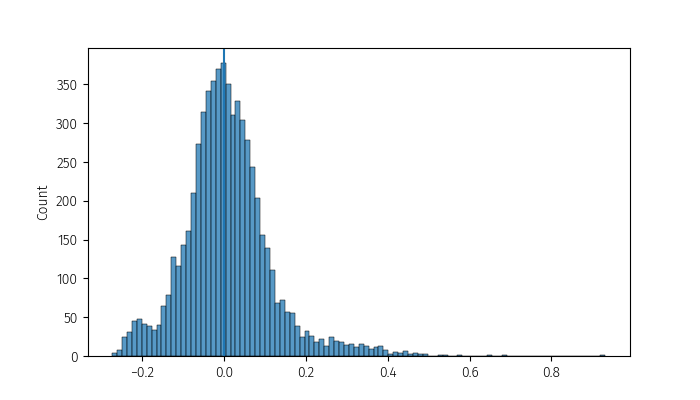

In [66]:
fig, ax = plt.subplots(1,1,figsize=(7, 4))
mask = (df_supermaster['deformation_flag'] == 0)
sns.histplot( df_supermaster['air_snow_elevation'][mask] - df_supermaster['ATM_elev'].apply(lambda x: np.nanquantile(x, .5))[mask])

ax.axvline(0)

# ax.set_xlim(-.5,.5)

### SURFACE FEATURE (FYI, DEFORMED)

/var/folders/33/mb4rwg392ds1fw9l8rx1tnp80000gn/T/ipykernel_31502/3524097633.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcol = ax[0].pcolormesh(Y.T, SR_Wavelet_data_dict[site][overflight_nr]['elevation_axii'],


1
2
3


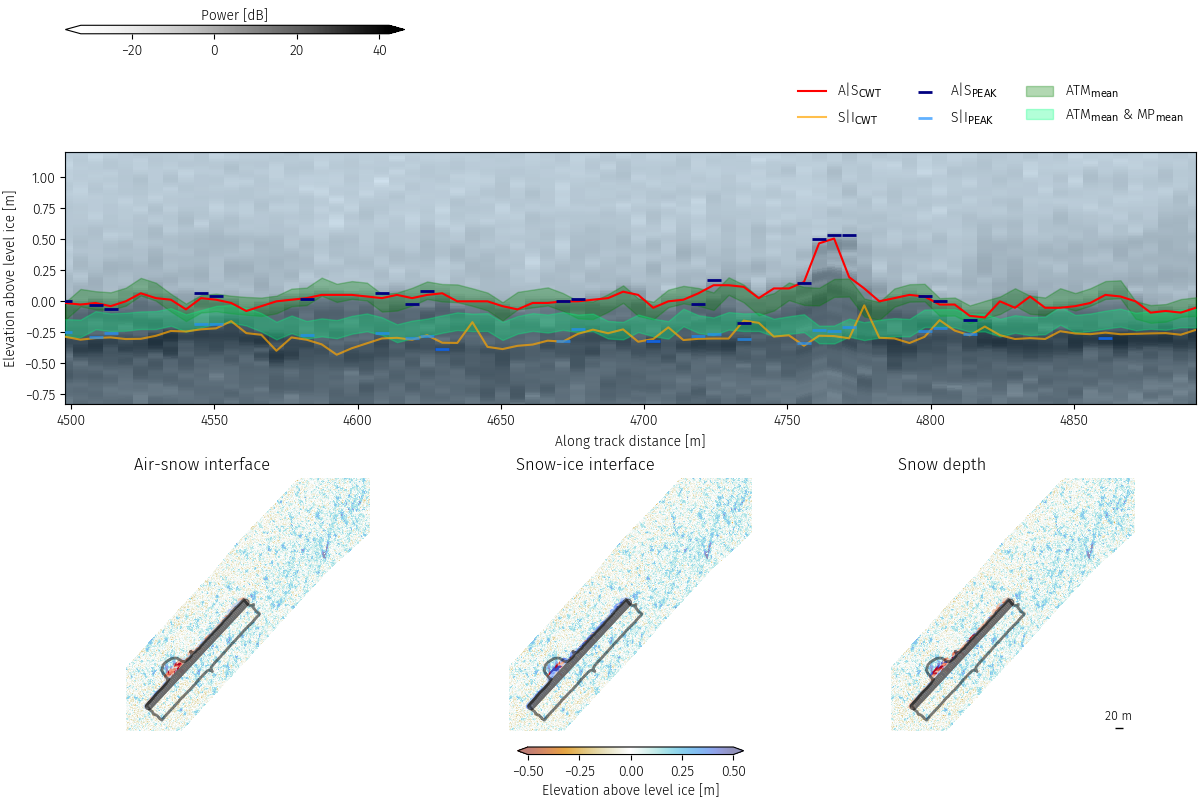

In [30]:
from matplotlib.gridspec import GridSpec

site = 'grid3'
overflight_nr = 0

pit_colors = ['C0', 'C1', 'C2']
df = df_master_dict[site]

fig = plt.figure(figsize=(12, 8), constrained_layout=True)

# Define a 2x3 grid with specific height ratios
gs = GridSpec(2, 3, height_ratios=[1, 1], figure=fig)
ax = [0] * 4
# Add a single plot for the top row spanning all columns
ax[0] = fig.add_subplot(gs[0, :])  # Row 0, all columns

# Add three plots for the bottom row
ax[1] = fig.add_subplot(gs[1, 0])  # Row 1, column 0
ax[2] = fig.add_subplot(gs[1, 1], sharex=ax[1], sharey=ax[1])  # Row 1, column 1
ax[3] = fig.add_subplot(gs[1, 2], sharex=ax[1], sharey=ax[1])  # Row 1, column 2

_, Y = np.meshgrid(range(len(SR_Wavelet_data_dict[site][overflight_nr]['range_bin'])), SR_Wavelet_data_dict[site][overflight_nr]['along_track_distance'])
pcol = ax[0].pcolormesh(Y.T, SR_Wavelet_data_dict[site][overflight_nr]['elevation_axii'],
                                        10 * np.log10(SR_Wavelet_data_dict[site][overflight_nr]['radar_data']),
                                        cmap='Greys',
                                        )
ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'], zorder=100000, color='red', label=r'A|S$_{\text{CWT}}$')
ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'], zorder=100000, color='orange', alpha=.7, label=r'S|I$_{\text{CWT}}$')

# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,f'air_snow_elevation_rolled_{5}'], zorder=100000, color='red',ls='--', alpha=.7)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,f'snow_ice_elevation_rolled_{5}'], zorder=100000, color='orange', alpha=.3,ls='--')
ax[0].scatter(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation_peakiness'], zorder=100000, color='navy', label=r'A|S$_{\text{PEAK}}$', s=100, marker='_',lw=2)
ax[0].scatter(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation_peakiness'], zorder=100000, color='dodgerblue', alpha=.7, label=r'S|I$_{\text{PEAK}}$', s=100, marker='_',lw=2)

# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
#               df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5)),
#                         zorder=50,
#                         color='green',
#                         )
ATM_error = np.sqrt(df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_uncertainty'].apply(lambda x: np.mean(x))**2 + 0.07**2)
ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
                df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5))-ATM_error,
                df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5))+ATM_error,
                alpha=0.3,
                zorder=10000,
                label=r'ATM$_{\text{mean}}$',
                color='green'
                )


MP_error = np.sqrt(df.loc[df['overflight_nr'] == overflight_nr,'MP_snow_depth_uncertainty'].apply(lambda x: np.nanmean(x))**2)
y =  df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) - df.loc[df['overflight_nr'] == overflight_nr,'MP_snow_depth'].apply(lambda x: np.nanmean(x))

ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
        y + np.sqrt(MP_error**2 + ATM_error**2),
        y - np.sqrt(MP_error**2 + ATM_error**2),
        color='springgreen',
        alpha=.3,
        zorder=10000,
        label=r'ATM$_{\text{mean}}$ & MP$_{\text{mean}}$'
        )

#add snow pit locations

# for i, pit_nr in enumerate(snow_pit_dict[site].keys()):
#     closest_along = snow_pit_dict[site][pit_nr]['x'], 
#     closest_along = df.loc[df['overflight_nr'] == overflight_nr].iloc[np.argmin((df.loc[df['overflight_nr'] == overflight_nr,'y'] - snow_pit_dict[site][pit_nr]['y'][0])**2 + (df.loc[df['overflight_nr'] == overflight_nr,'x'] - snow_pit_dict[site][pit_nr]['x'][0])**2)]['along_track_distance']
#     ax[0].axvline(closest_along, color=pit_colors[i],ls='--', label='Snow pit' if pit_nr == list(snow_pit_dict[site].keys())[0] else None)


ax[0].set_ylim(min(df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation']) -0.4, max(df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation']) + 0.7)
ax[0].set_xlim(min(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']), max(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']))


ax[0].set_ylabel('Elevation above level ice [m]')
ax[0].set_xlabel('Along track distance [m]')
cbar = fig.colorbar(pcol, ax=ax[0], orientation='horizontal',location='top',
                    anchor=(0,0.85),
                    label='Power [dB]',
                    shrink=.3,
                    extend='both',
                    aspect=40
                    )
cbar.ax.xaxis.set_ticks_position('bottom')

leg = ax[0].legend(loc='upper right',ncols=3, bbox_to_anchor=(1, 1.33), frameon=False)
leg.set_zorder(1000)

for i in range(1,4):
    print(i)
    ax[i].set_aspect('equal')
    ax[i].axis('off')
    ax[i].plot(shape_dict[site].geometry[0].exterior.xy[0], shape_dict[site].geometry[0].exterior.xy[1], color='black', linewidth=2, zorder=1000, alpha=.5) 
    xlim = ax[i].get_xlim()    
    ylim = ax[i].get_ylim()
    for fp in df['footprints']:
        plot_polygon(ax[i], fp, edgecolor='grey', facecolor='none', zorder=100, lw=.1, alpha=.7)
        
    for fp, dist in zip(df.loc[df['overflight_nr'] == overflight_nr,'footprints'], df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']):
        plot_polygon(ax[i], fp, edgecolor='dimgrey', facecolor='none', zorder=500, lw=1, alpha=.7)
        
    pcol = ax[i].pcolormesh(ATM_data_dict[site]['easting'], ATM_data_dict[site]['northing'], ATM_data_dict[site]['elevation'],
                cmap=cmr.prinsenvlag,
                norm=mcolors.TwoSlopeNorm(vmin=-.5, vcenter=0 , vmax=.5),
                alpha=.75,
                )


cbar = fig.colorbar(pcol, ax=ax[1:4],
                    orientation='horizontal',
                    label='Elevation above level ice [m]',
                    shrink=.2,
                    extend='both',
                    aspect=30,
                    # anchor=(1.74,0.5),
                    )
# cbar.ax.xaxis.set_label_position('top')


ax[1].set_title('Air-snow interface', ha='left', x=0.03)
ax[2].set_title('Snow-ice interface', ha='left', x=0.03)
ax[3].set_title('Snow depth', ha='left', x=0.03)

# for i, pit_nr in enumerate(snow_pit_dict[site].keys()):
#     ax[1].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
#     ax[2].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
#     ax[3].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
    
scat = ax[1].scatter(df['x'], df['y'], c=df['air_snow_elevation'] - df['ATM_elev_wavelet'].apply(lambda x: np.nanquantile(x, .5)),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )

scat = ax[1].scatter(df.loc[df['overflight_nr'] == overflight_nr]['x'], df.loc[df['overflight_nr'] == overflight_nr]['y'], c=df.loc[df['overflight_nr'] == overflight_nr]['air_snow_elevation'] - df.loc[df['overflight_nr'] == overflight_nr]['ATM_elev_wavelet'].apply(lambda x: np.nanquantile(x, .5)),
        s=20,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=210,
        edgecolors='dimgrey',
        )

# cbar = fig.colorbar(scat, ax=ax[1], orientation='horizontal',
#                     label=r'Difference A|S$_{\text{CWT}}$ and $\overline{\text{H}_{\text{e,ATM}}}$ [m]',
#                     shrink=.5,
#                     extend='both',
#                     anchor=(0.5,1),
                    
#                     )

scat = ax[2].scatter(df['x'], df['y'], c=df['snow_ice_elevation'] - (df['ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) -  df['MP_snow_depth'].apply(lambda x: np.nanmean(x))),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )
scat = ax[2].scatter(df.loc[df['overflight_nr'] == overflight_nr]['x'], df.loc[df['overflight_nr'] == overflight_nr]['y'], c= df.loc[df['overflight_nr'] == overflight_nr]['snow_ice_elevation'] - ( df.loc[df['overflight_nr'] == overflight_nr]['ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) -   df.loc[df['overflight_nr'] == overflight_nr]['MP_snow_depth'].apply(lambda x: np.nanmean(x))),
        s=20,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=210,
        alpha=1,
        edgecolors='dimgrey',
        )
# cbar = fig.colorbar(scat, ax=ax[2], orientation='horizontal',
#                     label=r'Difference S|I$_{\text{CWT}}$ and $\overline{\text{H}_{\text{e,ATM}}}$ - $\overline{\text{h}_{\text{s,MP}}}$ [m]',
#                     shrink=.5,
#                     extend='both',
#                     anchor=(0.5,1),
                    
                #     )

scat = ax[3].scatter(df['x'], df['y'], c=df['snow_depth'] - df['MP_snow_depth'].apply(lambda x: np.nanquantile(x, .9)),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200,
        alpha=1
        )
scat = ax[3].scatter(df.loc[df['overflight_nr'] == overflight_nr]['x'], df.loc[df['overflight_nr'] == overflight_nr]['y'], c=df.loc[df['overflight_nr'] == overflight_nr]['snow_depth'] - df.loc[df['overflight_nr'] == overflight_nr]['MP_snow_depth'].apply(lambda x: np.nanquantile(x, .9)),
        s=20,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=210,
        alpha=1,
        edgecolors='dimgrey',
        )


# cbar = fig.colorbar(scat, ax=ax[3], orientation='horizontal',
#                     label=r'Difference h$_{\text{s, cCWT}}$ - $\overline{\text{h}_{s,\text{MP}}}$ [m]',
#                     shrink=.5,
#                     extend='both',
#                     anchor=(0.5,1),
#                     # 
#                     )

for i in range(1,4):
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
    
xlim_low = ax[1].get_xlim()[0]
xlim_high = ax[1].get_xlim()[1]

ylim_low = ax[1].get_ylim()[0]
ylim_high = ax[1].get_ylim()[1]

df_f = df.loc[df['overflight_nr'] == overflight_nr]
df_subset = df_f.loc[(df_f['x'] > xlim_low) & (df_f['x'] < xlim_high) & (df_f['y'] > ylim_low) & (df_f['y'] < ylim_high)]
along_min = df_subset['along_track_distance'].min()
along_max = df_subset['along_track_distance'].max()
vspan = ax[0].axvspan(along_min, along_max, zorder=100, alpha=.2, edgecolor='black')

scalebar = AnchoredSizeBar(ax[3].transData,
                           20, '20 m', 'lower right', 
                        #    pad=-1,
                           color='black',
                           frameon=False,
                           fill_bar=True,
                           size_vertical=1,
                           label_top=True,
                           sep=4,
                           fontproperties=font_manager.FontProperties(family='Fira Sans', size=9),
                           zorder=1000
                           )
ax[3].add_artist(scalebar)

def update_vspan(event):
    xlim_low, xlim_high = ax[1].get_xlim()
    df_subset = df_f.loc[(df_f['x'] > xlim_low) & (df_f['x'] < xlim_high) & (df_f['y'] > ylim_low) & (df_f['y'] < ylim_high)]
    along_min = df_subset['along_track_distance'].min()
    along_max = df_subset['along_track_distance'].max()

    points = np.array([[along_min, ax[0].get_ylim()[0]], [along_max, ax[0].get_ylim()[0]], [along_max, ax[0].get_ylim()[1]], [along_min, ax[0].get_ylim()[1]]])
    vspan.set_xy(points )
    fig.canvas.draw_idle()

ax[1].callbacks.connect('xlim_changed', update_vspan)

# fig.tight_layout() 
plt.show()


### MYI, UNDEFORMED & DEFORMED (GRID5)

### MYI, ROUGH (GRID8)

In [1]:
from matplotlib.gridspec import GridSpec

site = 'grid5'
overflight_nr = 1

pit_colors = ['C0', 'C1', 'C2']
df = df_master_dict[site]
df = df.loc[df['x'] > -7.1864e5]
fig = plt.figure(figsize=(12, 8))

# Define a 2x3 grid with specific height ratios
gs = GridSpec(2, 3, height_ratios=[1, 2], figure=fig)
ax = [0] * 4
# Add a single plot for the top row spanning all columns
ax[0] = fig.add_subplot(gs[0, :])  # Row 0, all columns

# Add three plots for the bottom row
ax[1] = fig.add_subplot(gs[1, 0])  # Row 1, column 0
ax[2] = fig.add_subplot(gs[1, 1], sharex=ax[1], sharey=ax[1])  # Row 1, column 1
ax[3] = fig.add_subplot(gs[1, 2], sharex=ax[1], sharey=ax[1])  # Row 1, column 2



#ECHOGRAM
_, Y = np.meshgrid(range(len(SR_Wavelet_data_dict[site][overflight_nr]['range_bin'])), SR_Wavelet_data_dict[site][overflight_nr]['along_track_distance'])
pcol = ax[0].pcolormesh(Y.T, SR_Wavelet_data_dict[site][overflight_nr]['elevation_axii'],
                                        10 * np.log10(SR_Wavelet_data_dict[site][overflight_nr]['radar_data']),
                                        cmap='Greys',
                                        )

#CWT INTERFACES

#CWT INTERFACES
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'], zorder=100000, color='red')
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'].rolling(window=3,center=True, min_periods=1).mean(), df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'].rolling(window=3,center=True, min_periods=1).mean(), zorder=100000, color='red')

ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
        df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'] + df.loc[df['overflight_nr'] == overflight_nr,'precision'],
        df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation'] - df.loc[df['overflight_nr'] == overflight_nr,'precision'],
        color='red',
        alpha=.7,
        zorder=10000,
        label=r'A|S$_{\text{CWT}}$'
        )

# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'], zorder=100000, color='orange', alpha=.7)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'].rolling(window=3,center=True, min_periods=1).mean(), df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'].rolling(window=3,center=True, min_periods=1).mean(), zorder=100000, color='orange')

ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
        df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'] + df.loc[df['overflight_nr'] == overflight_nr,'precision'],
        df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation'] - df.loc[df['overflight_nr'] == overflight_nr,'precision'],
        color='orange',
        alpha=.7,
        zorder=10000,
        label=r'S|I$_{\text{CWT}}$'
        )

#PEAK INTERFACES
ax[0].scatter(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation_peakiness'], zorder=100000, color='navy', label=r'A|S$_{\text{PEAK}}$', s=100, marker='_',lw=2)
ax[0].scatter(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation_peakiness'], zorder=100000, color='dodgerblue', alpha=.7, label=r'S|I$_{\text{PEAK}}$', s=100, marker='_',lw=2)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,f'air_snow_elevation_rolled_{5}'], zorder=100000, color='red',ls='--', alpha=.7)
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,f'snow_ice_elevation_rolled_{5}'], zorder=100000, color='orange', alpha=.3,ls='--')
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation_peakiness_offset'], zorder=100000, color='navy', label=r'A|S$_{\text{PEAK}}$')
# ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'], df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation_peakiness_offset'], zorder=100000, color='deepskyblue', alpha=.7, label=r'S|I$_{\text{PEAK}}$')

#ATM A\S INTERFACE
ax[0].plot(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
              df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5)),
                        zorder=50,
                        color='green',
                        )
ATM_error = np.sqrt(df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_uncertainty'].apply(lambda x: np.mean(x))**2 + 0.07**2)
ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
                df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5))-ATM_error,
                df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.quantile(x, .5))+ATM_error,
                alpha=0.3,
                zorder=10000,
                label=r'ATM$_{\text{mean}}$',
                color='green'
                )

#ATM&MP S\I INTERFACE
MP_error = np.sqrt(df.loc[df['overflight_nr'] == overflight_nr,'MP_snow_depth_uncertainty'].apply(lambda x: np.nanmean(x))**2)
y =  df.loc[df['overflight_nr'] == overflight_nr,'ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) - df.loc[df['overflight_nr'] == overflight_nr,'MP_snow_depth'].apply(lambda x: np.nanmean(x))

ax[0].fill_between(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance'],
        y + np.sqrt(MP_error**2 + ATM_error**2),
        y - np.sqrt(MP_error**2 + ATM_error**2),
        color='springgreen',
        alpha=.3,
        zorder=10000,
        label=r'ATM$_{\text{mean}}$ & MP$_{\text{mean}}$'
        )

#add snow pit locations

# for i, pit_nr in enumerate(snow_pit_dict[site].keys()):
#     closest_along = snow_pit_dict[site][pit_nr]['x'], 
#     closest_along = df.loc[df['overflight_nr'] == overflight_nr].iloc[np.argmin((df.loc[df['overflight_nr'] == overflight_nr,'y'] - snow_pit_dict[site][pit_nr]['y'][0])**2 + (df.loc[df['overflight_nr'] == overflight_nr,'x'] - snow_pit_dict[site][pit_nr]['x'][0])**2)]['along_track_distance']
#     ax[0].axvline(closest_along, color=pit_colors[i],ls='--', label='Snow pit' if pit_nr == list(snow_pit_dict[site].keys())[0] else None)


ax[0].set_ylim(min(df.loc[df['overflight_nr'] == overflight_nr,'snow_ice_elevation']) -0.2, max(df.loc[df['overflight_nr'] == overflight_nr,'air_snow_elevation']) + 0.7)
ax[0].set_xlim(min(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']), max(df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']))


ax[0].set_ylabel('Elevation above level ice [m]')
ax[0].set_xlabel('Along track distance [m]')
cbar = fig.colorbar(pcol, ax=ax[0], orientation='horizontal',location='top',
                    anchor=(0,0.85),
                    label='Power [dB]',
                    shrink=.3,
                    extend='both',
                    aspect=40
                    )
cbar.ax.xaxis.set_ticks_position('bottom')

leg = ax[0].legend(loc='upper right',ncols=3, bbox_to_anchor=(1, 1.33), frameon=False)
leg.set_zorder(1000)

for i in range(1,4):
    print(i)
    ax[i].set_aspect('equal')
    ax[i].axis('off')
    ax[i].plot(shape_dict[site].geometry[0].exterior.xy[0], shape_dict[site].geometry[0].exterior.xy[1], color='black', linewidth=2, zorder=1000, alpha=.5) 
    xlim = ax[i].get_xlim()    
    ylim = ax[i].get_ylim()
    for fp in df['footprints']:
        plot_polygon(ax[i], fp, edgecolor='grey', facecolor='none', zorder=100, lw=.1, alpha=.7)
        
    for fp, dist in zip(df.loc[df['overflight_nr'] == overflight_nr,'footprints'], df.loc[df['overflight_nr'] == overflight_nr,'along_track_distance']):
        plot_polygon(ax[i], fp, edgecolor='dimgrey', facecolor='none', zorder=500, lw=1, alpha=.7)
        
    pcol = ax[i].pcolormesh(ATM_data_dict[site]['easting'], ATM_data_dict[site]['northing'], ATM_data_dict[site]['elevation'],
                cmap=cmr.prinsenvlag,
                norm=mcolors.TwoSlopeNorm(vmin=-2.5, vcenter=0 , vmax=2.5),
                alpha=.75,
                )


cbar = fig.colorbar(pcol, ax=ax[1:4],
                    orientation='horizontal',
                    label='Elevation above level ice [m]',
                    shrink=.3,
                    extend='both',
                    aspect=30,
                    # anchor=(1.74,0.5),
                    )
# cbar.ax.xaxis.set_label_position('top')


ax[1].set_title('Air-snow interface', ha='left', x=0.03)
ax[2].set_title('Snow-ice interface', ha='left', x=0.03)
ax[3].set_title('Snow depth', ha='left', x=0.03)

# for i, pit_nr in enumerate(snow_pit_dict[site].keys()):
#     ax[1].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
#     ax[2].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
#     ax[3].scatter(snow_pit_dict[site][pit_nr]['x'], snow_pit_dict[site][pit_nr]['y'],  color=pit_colors[i], marker='*', s=20, zorder=1000)
    
scat = ax[1].scatter(df['x'], df['y'], c=df['air_snow_elevation'] - df['ATM_elev_wavelet'].apply(lambda x: np.nanquantile(x, .5)),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )

scat = ax[1].scatter(df.loc[df['overflight_nr'] == overflight_nr]['x'], df.loc[df['overflight_nr'] == overflight_nr]['y'], c=df.loc[df['overflight_nr'] == overflight_nr]['air_snow_elevation'] - df.loc[df['overflight_nr'] == overflight_nr]['ATM_elev_wavelet'].apply(lambda x: np.nanquantile(x, .5)),
        s=20,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=210,
        edgecolors='dimgrey',
        )

cbar = fig.colorbar(scat, ax=ax[1], orientation='horizontal',
                    label=r'Difference A|S$_{\text{CWT}}$ and $\overline{\text{H}_{\text{e,ATM}}}$ [m]',
                    shrink=.5,
                    extend='both',
                    anchor=(0.5,1),
                    
                    )

scat = ax[2].scatter(df['x'], df['y'], c=df['snow_ice_elevation'] - (df['ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) -  df['MP_snow_depth'].apply(lambda x: np.nanmean(x))),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200
        )
scat = ax[2].scatter(df.loc[df['overflight_nr'] == overflight_nr]['x'], df.loc[df['overflight_nr'] == overflight_nr]['y'], c= df.loc[df['overflight_nr'] == overflight_nr]['snow_ice_elevation'] - ( df.loc[df['overflight_nr'] == overflight_nr]['ATM_elev_wavelet'].apply(lambda x: np.nanmean(x)) -   df.loc[df['overflight_nr'] == overflight_nr]['MP_snow_depth'].apply(lambda x: np.nanmean(x))),
        s=20,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=210,
        alpha=1,
        edgecolors='dimgrey',
        )
cbar = fig.colorbar(scat, ax=ax[2], orientation='horizontal',
                    label=r'Difference S|I$_{\text{CWT}}$ and $\overline{\text{H}_{\text{e,ATM}}}$ - $\overline{\text{h}_{\text{s,MP}}}$ [m]',
                    shrink=.5,
                    extend='both',
                    anchor=(0.5,1),
                    
                    )

scat = ax[3].scatter(df['x'], df['y'], c=df['snow_depth'] - df['MP_snow_depth'].apply(lambda x: np.nanquantile(x, .9)),
        s=10,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=200,
        alpha=1
        )
scat = ax[3].scatter(df.loc[df['overflight_nr'] == overflight_nr]['x'], df.loc[df['overflight_nr'] == overflight_nr]['y'], c=df.loc[df['overflight_nr'] == overflight_nr]['snow_depth'] - df.loc[df['overflight_nr'] == overflight_nr]['MP_snow_depth'].apply(lambda x: np.nanquantile(x, .9)),
        s=20,
        cmap='coolwarm',
        norm=mcolors.TwoSlopeNorm(vmin=-.2, vcenter=0, vmax=.2),
        zorder=210,
        alpha=1,
        edgecolors='dimgrey',
        )


cbar = fig.colorbar(scat, ax=ax[3], orientation='horizontal',
                    label=r'Difference h$_{\text{s, cCWT}}$ - $\overline{\text{h}_{s,\text{MP}}}$ [m]',
                    shrink=.5,
                    extend='both',
                    anchor=(0.5,1),
                    # 
                    )

for i in range(1,4):
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
    
xlim_low = ax[1].get_xlim()[0]
xlim_high = ax[1].get_xlim()[1]

ylim_low = ax[1].get_ylim()[0]
ylim_high = ax[1].get_ylim()[1]

df_f = df.loc[df['overflight_nr'] == overflight_nr]
df_subset = df_f.loc[(df_f['x'] > xlim_low) & (df_f['x'] < xlim_high) & (df_f['y'] > ylim_low) & (df_f['y'] < ylim_high)]
along_min = df_subset['along_track_distance'].min()
along_max = df_subset['along_track_distance'].max()
vspan = ax[0].axvspan(along_min, along_max, zorder=100, alpha=.2, edgecolor='black')

scalebar = AnchoredSizeBar(ax[3].transData,
                           20, '20 m', 'lower left', 
                        #    pad=-1,
                           color='black',
                           frameon=False,
                           fill_bar=True,
                           size_vertical=1,
                           label_top=True,
                           sep=4,
                           fontproperties=font_manager.FontProperties(family='Fira Sans', size=9),
                           zorder=1000
                           )
ax[3].add_artist(scalebar)

def update_vspan(event):
    xlim_low, xlim_high = ax[1].get_xlim()
    df_subset = df_f.loc[(df_f['x'] > xlim_low) & (df_f['x'] < xlim_high) & (df_f['y'] > ylim_low) & (df_f['y'] < ylim_high)]
    along_min = df_subset['along_track_distance'].min()
    along_max = df_subset['along_track_distance'].max()

    points = np.array([[along_min, ax[0].get_ylim()[0]], [along_max, ax[0].get_ylim()[0]], [along_max, ax[0].get_ylim()[1]], [along_min, ax[0].get_ylim()[1]]])
    vspan.set_xy(points )
    fig.canvas.draw_idle()

ax[1].callbacks.connect('xlim_changed', update_vspan)
ax[0].set_xlim(0,500)
fig.tight_layout() 
plt.show()


NameError: name 'df_master_dict' is not defined

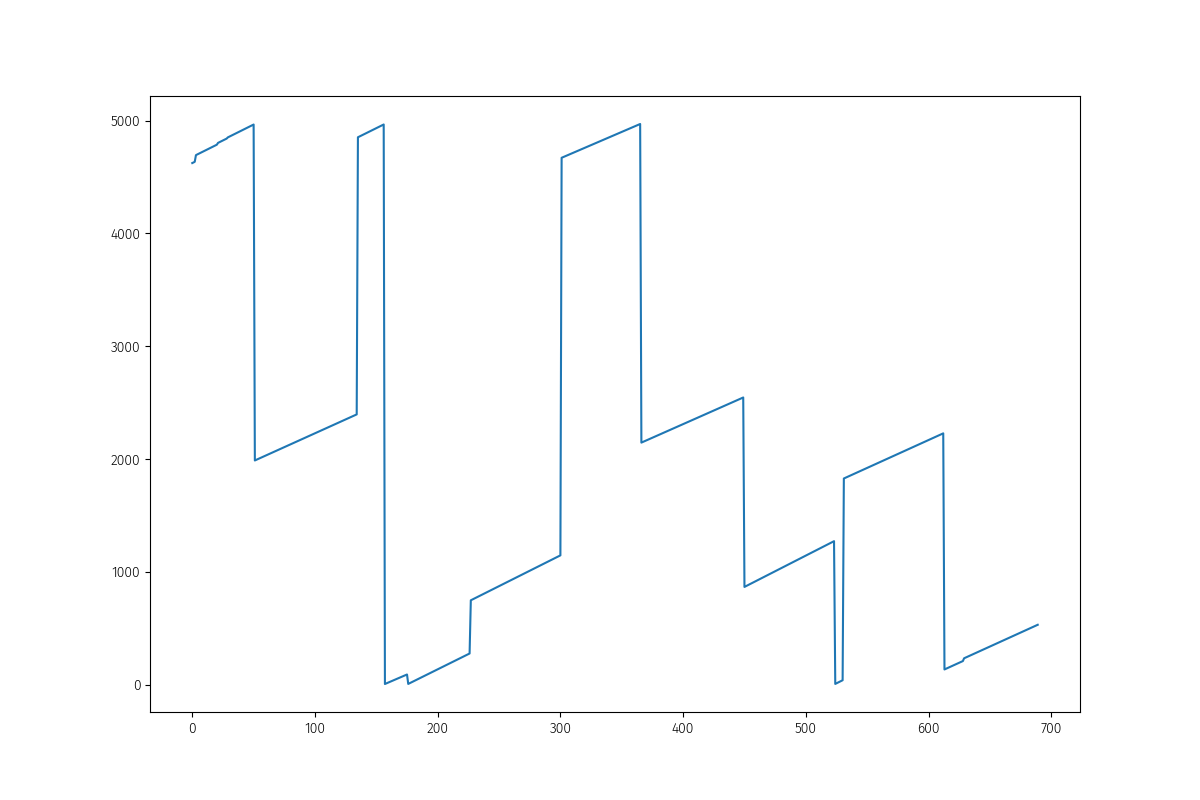

In [40]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
ax.plot(df['along_track_distance'])